In [1]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

In [29]:
im = plt.imread("image/noise_2.jpg")
im.shape

(1357, 2048, 3)

3层的图像数据，前两层是像素的X,Y坐标，第三层是像素的RGM颜色值，我们把它画出来

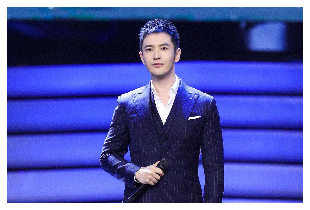

In [30]:
# matplotlib跟jupyter结合在一起真的是一个很便利的工具

def plti(im, h=8, **kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')
    
plti(im)

那么首先，尝试用numpy把图片灰度化，既然第三层是RGB值，我们直接从RGB层中取出权重即可

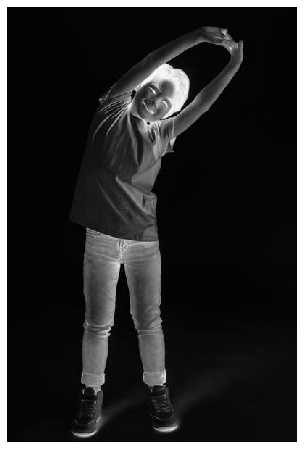

In [21]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    默认参数是转化的权重
    """
    tile = np.tile(weights, reps=(im.shape[0], im.shape[1], 1))
    return np.sum(tile * im, axis = 2)

img = to_grayscale(im)
plti(img, cmap = 'Greys')

Wall time: 695 ms


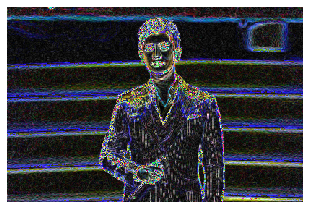

In [38]:
%%time
from scipy.ndimage.interpolation import zoom
from scipy.signal import convolve2d
im_small = zoom(im, (0.2,0.2,1))

n=100
sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_small[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_small[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

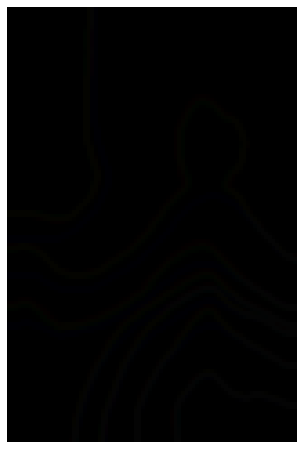

In [23]:
from scipy.ndimage import median_filter

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

im_smoothed = median_filter_all_colours(im_small, 71)

sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_smoothed[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_smoothed[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

上面是卷积（滑窗）的一些操作，重头戏像素分割来了


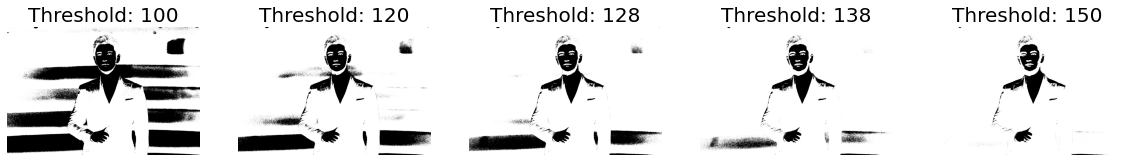

In [31]:
def simple_threshold(im, threshold=128):
    return ((im > threshold) * 255).astype("uint8")

thresholds = [100,120,128,138,150]

fig, axs = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(20,5));
gray_im = to_grayscale(im)
                        
for t, ax in zip(thresholds, axs):
    ax.imshow(simple_threshold(gray_im, t), cmap='Greys');
    ax.set_title("Threshold: {}".format(t), fontsize=20);
    ax.set_axis_off();

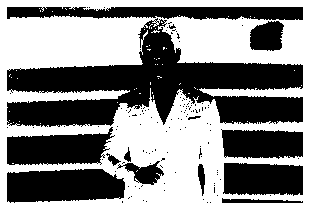

In [32]:
def otsu_threshold(im):

    pixel_counts = [np.sum(im == i) for i in range(256)]

    s_max = (0,-10)
    ss = []
    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0

        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)

        if s > s_max[1]:
            s_max = (threshold, s)
            
    return s_max[0]

t = otsu_threshold(gray_im)
plti(simple_threshold(gray_im, t), cmap='Greys')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in long_scalars


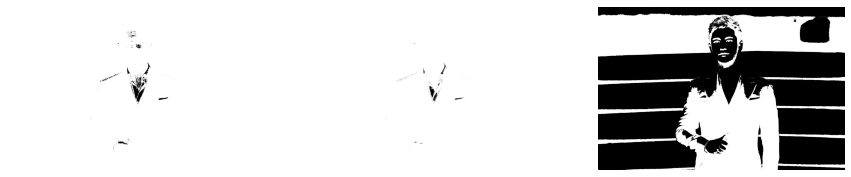

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

c_ims = []
for c, ax in zip(range(3), axs):
    tmp_im = im[:,:,c]
    t = otsu_threshold(tmp_im)
    tmp_im = simple_threshold(tmp_im, t)
    ax.imshow(tmp_im, cmap='Greys')
    c_ims.append(tmp_im)
    ax.set_axis_off()

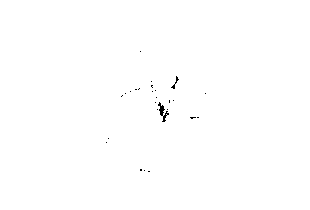

In [34]:
plti(c_ims[0] & c_ims[1] & c_ims[2], cmap='Greys')

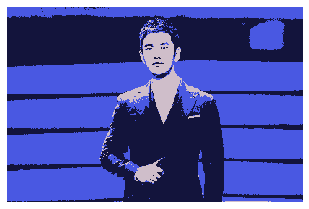

In [39]:
from sklearn.cluster import KMeans

h,w = im_small.shape[:2]
im_small_long = im_small.reshape((h * w, 3))
im_small_wide = im_small_long.reshape((h,w,3))

km = KMeans(n_clusters=3)

km.fit(im_small_long)

cc = km.cluster_centers_.astype(np.uint8)
out = np.asarray([cc[i] for i in km.labels_]).reshape((h,w,3))

plti(out)

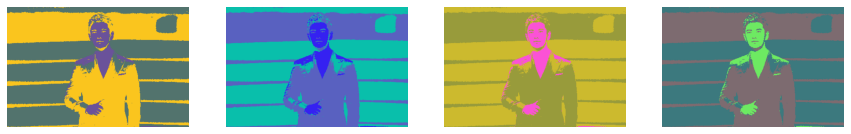

In [40]:
rng = range(4)

fig, axs = plt.subplots(nrows=1, ncols=len(rng), figsize=(15,5))
gray_im = to_grayscale(im)
                        
for t, ax in zip(rng, axs):
    rnd_cc = np.random.randint(0,256, size = (3,3))
    out = np.asarray([rnd_cc[i] for i in km.labels_]).reshape((h,w,3))
    ax.imshow(out)
    ax.set_axis_off()

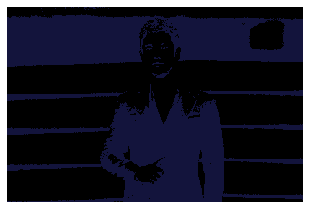

In [41]:
dog = np.asarray([cc[i] if i == 1 else [0,0,0]
                  for i in km.labels_]).reshape((h,w,3))

plti(dog)